# 락 성능 분석 결과 리포트

### 라이브러리 import, 데이터 형태 확인용 함수 작성

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def validateDir(path: str):
    assert os.path.exists(path) and os.path.isdir(path), '경로에 디렉토리가 존재하지 않습니다.'

def convert_to_numeric(df):
    numeric_feature = df.columns[(df.dtypes==int) | (df.dtypes== float)]
    categorical_feature = df.columns[df.dtypes=='O']
    
    print("수치형 컬럼 : ", list(numeric_feature))
    print("카테고리형 컬럼 : ", list(categorical_feature))
    
    for col in categorical_feature:
        if isinstance(df[col][0], int) or (isinstance(df[col][0],str) and df[col][0].isnumeric()):
            df[col] = pd.to_numeric(df[col])
    
    print("숫자값을 수치형 컬럼으로 변환합니다.")
    print(df.dtypes)


def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼: {col}')
            print(f'해당 컬럼의 결측치 수: {missing_values}')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col
    

### 특정 그룹별 duration 통계 (vus, conflict_rate로 필터링) 함수

In [7]:
def show_mean_duration_for(df, min_vus = 0, max_vus = 10000000, min_conflict_rate=0, max_conflict_rate=10000000, groupby_columns = []):
    print(f'\n(min_vus : {min_vus}, max_vus : {max_vus}, min_conflict_rate : {min_conflict_rate:.2f}, max_conflict_rate : {max_conflict_rate:.2f}) 조건에서의 통계 분석')
    df = df.loc[(df.vus >= min_vus)&(df.vus <= max_vus)&(df.conflict_rate >= min_conflict_rate)&(df.conflict_rate <= max_conflict_rate),:]
    
    print('\nduration 순으로 상위 5개')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.sort_values(['duration']).head(5))
    
    if groupby_columns:
        print('\n',groupby_columns, '별 duration 평균값')
        print(df.loc[:, ['duration']+groupby_columns].groupby(groupby_columns).mean())
        print('\n',groupby_columns, '별 duration 최소값')
        print(df.loc[:, ['duration']+groupby_columns].groupby(groupby_columns).min())
    else:
        print('\n평균 duration')
        print(df.mean())
        print('\n최소 duration')
        print(df.min())

### 변수 간 상관관계 그래프 함수

In [8]:
def corr_between_feature_target(df, feature, target):
    plt.figure(figsize=(15,10))

    heat_table = df.corr(method="kendall")
    mask = np.zeros_like(heat_table)
    mask[np.triu_indices_from(mask)] = True
    heatmap_ax = sns.heatmap(heat_table, annot=True, mask=mask, cmap='coolwarm')
    heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
    heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
    plt.title('correlation between features', fontsize=20)
    plt.show()
    
    '''
    numeric_feature = ['conflict_rate']

    plt.figure(figsize=(20,15))
    plt.suptitle("Pearson Scatter Plot", fontsize=15)
    
    for i in range(len(numeric_feature)):
        plt.subplot(2,3,i+1)
        plt.xlabel(numeric_feature[i])
        plt.ylabel(target)
        corr_score = df[[numeric_feature[i], target]].corr().iloc[0,1].round(2)
        c = 'red' if corr_score > 0 else 'blue'
        plt.scatter(df[numeric_feature[i]], df[target], color=c, label=f"corr = {corr_score}")
        plt.legend(fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    
    categorical_feature = [col for col in feature if col not in ['conflict_rate']]
    print(categorical_feature)

    plt.figure(figsize=(20,15))
    plt.suptitle("Violin Plot", fontsize=15)
    
    for i in range(len(categorical_feature)):
        print(i+1, categorical_feature[i])
        plt.subplot(3,2,i+1)
        plt.xlabel(categorical_feature[i])
        plt.ylabel(target)
        sns.violinplot(x= df[categorical_feature[i]], y= df[target])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    '''

# 1. 성능 분석 시작

## 1.1 성능 데이터 로드

In [9]:
path = os.getcwd()+'./result'
validateDir(path)

df = pd.DataFrame(columns=['lock', 'vus', 'tickets', 'minBackoff', 'maxBackoff', 'retry', 'waitTime', 'leaseTime', 'duration', 'passes', 'fails'])
subdir_names=os.listdir(path)
for file_name in subdir_names:
    if file_name == 'result_2.csv':
        df1 = pd.read_csv(path+"\\"+file_name, index_col = 0)
        df= pd.concat([df, df1])

convert_to_numeric(df)

수치형 컬럼 :  ['duration', 'passes', 'fails']
카테고리형 컬럼 :  ['lock', 'vus', 'tickets', 'minBackoff', 'maxBackoff', 'retry', 'waitTime', 'leaseTime']
숫자값을 수치형 컬럼으로 변환합니다.
lock           object
vus             int64
tickets         int64
minBackoff      int64
maxBackoff      int64
retry           int64
waitTime        int64
leaseTime       int64
duration      float64
passes        float64
fails         float64
dtype: object


In [10]:
df['pass_rate'] = df['passes'] /np.minimum(df['vus'], df['tickets'])
df['conflict_rate'] = df['vus'] / df['tickets']
df = df.round(2)

## 1.2 pass_rate가 1 미만인 항목 출력

In [11]:
print(df.loc[(df.pass_rate < 1) & (df.waitTime >= 1000), ['lock','vus','tickets', 'waitTime', 'leaseTime', 'pass_rate']])
df = df.drop(['passes', 'fails'], axis=1)

       lock  vus  tickets  waitTime  leaseTime  pass_rate
56   d-lock   30     1000      1000        500       0.95
108  d-lock   50     1000      1000       1000       0.66
109  d-lock   50     1000      1000       1500       0.67
110  d-lock   50     1000      1000        500       0.64
126  d-lock   50      100      1000       1000       0.63
127  d-lock   50      100      1000       1500       0.64
128  d-lock   50      100      1000        500       0.62


## 1.3 최소 pass_rate 설정

In [12]:
pass_rate = 0.98

df = df.loc[df['pass_rate'] >= pass_rate, :]

## 1.4 olock, plock, dlock 별 데이터 분리

In [13]:
common_columns = ['vus', 'tickets', 'duration', 'conflict_rate']
olock_columns = ['minBackoff', 'maxBackoff','retry']
plock_columns = []
dlock_columns =['waitTime', 'leaseTime']
o_df = df.loc[df.lock == 'o-lock', common_columns + olock_columns]
p_df = df.loc[df.lock == 'p-lock', common_columns + plock_columns]
d_df = df.loc[df.lock == 'd-lock', common_columns + dlock_columns]

# 2. 낙관적 락

## 2.1 낙관적 락 데이터 확인

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(o_df.sort_values(['vus','tickets','duration']))

     vus  tickets  duration  conflict_rate  minBackoff  maxBackoff  retry
182   10       10    112.04           1.00         100         200     90
180   10       10    113.56           1.00         100         200     30
181   10       10    120.27           1.00         100         200     60
185   10       10    136.93           1.00         100         300     90
183   10       10    139.92           1.00         100         300     30
184   10       10    148.53           1.00         100         300     60
186   10       10    164.05           1.00         100         400     30
187   10       10    169.36           1.00         100         400     60
188   10       10    197.57           1.00         100         400     90
177   10      100     61.67           0.10         100         400     30
173   10      100     61.80           0.10         100         200     90
171   10      100     62.55           0.10         100         200     30
175   10      100     63.37           

## 2.2 minBackoff,  maxBackoff, retry 별 duration 확인

In [15]:
# print(o_df.groupby(['maxBackoff', 'retry']).mean())
show_mean_duration_for(o_df,max_conflict_rate=1, groupby_columns=olock_columns)
# show_mean_duration_for(o_df, max_vus=50, groupby_columns=olock_columns)

#feature = [col for col in o_df.columns if col not in ['duration']]
#target = 'duration'
#corr_between_feature_target(o_df, feature, target)


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 1.00) 조건에서의 통계 분석

duration 순으로 상위 5개
     vus  tickets  duration  conflict_rate  minBackoff  maxBackoff  retry
177   10      100     61.67            0.1         100         400     30
173   10      100     61.80            0.1         100         200     90
171   10      100     62.55            0.1         100         200     30
175   10      100     63.37            0.1         100         300     60
174   10      100     64.33            0.1         100         300     30

 ['minBackoff', 'maxBackoff', 'retry'] 별 duration 평균값
                               duration
minBackoff maxBackoff retry            
100        200        30     159.612857
                      60     161.847143
                      90     160.281429
           300        30     168.247143
                      60     168.287143
                      90     167.535714
           400        30     167.887143
                      

## 2.3 vus, tickets별 duration 확인

In [16]:
show_mean_duration_for(o_df, groupby_columns=['vus','tickets'])


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 10000000.00) 조건에서의 통계 분석

duration 순으로 상위 5개
     vus  tickets  duration  conflict_rate  minBackoff  maxBackoff  retry
177   10      100     61.67            0.1         100         400     30
173   10      100     61.80            0.1         100         200     90
171   10      100     62.55            0.1         100         200     30
175   10      100     63.37            0.1         100         300     60
174   10      100     64.33            0.1         100         300     30

 ['vus', 'tickets'] 별 duration 평균값
               duration
vus tickets            
10  10       144.692222
    100       68.348889
    1000     244.267778
30  10       154.306667
    100      116.768889
    1000     183.815556
50  10       226.827778
    100      184.434444
    1000     220.336667

 ['vus', 'tickets'] 별 duration 최소값
             duration
vus tickets          
10  10         112.04
    100         61.67
    10

## 2.4 conflict_rate 별 duration 확인

In [17]:
show_mean_duration_for(o_df, groupby_columns=['tickets','conflict_rate'])


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 10000000.00) 조건에서의 통계 분석

duration 순으로 상위 5개
     vus  tickets  duration  conflict_rate  minBackoff  maxBackoff  retry
177   10      100     61.67            0.1         100         400     30
173   10      100     61.80            0.1         100         200     90
171   10      100     62.55            0.1         100         200     30
175   10      100     63.37            0.1         100         300     60
174   10      100     64.33            0.1         100         300     30

 ['tickets', 'conflict_rate'] 별 duration 평균값
                         duration
tickets conflict_rate            
10      1.00           144.692222
        3.00           154.306667
        5.00           226.827778
100     0.10            68.348889
        0.30           116.768889
        0.50           184.434444
1000    0.01           244.267778
        0.03           183.815556
        0.05           220.336667

 ['ticket

# 3. 비관적 락

## 3.1 비관적 락 데이터 확인

In [18]:
print(p_df)

     vus  tickets  duration  conflict_rate
243   10     1000    290.37           0.01
244   10      100    148.79           0.10
245   10       10    115.64           1.00
246   30     1000    302.69           0.03
247   30      100    234.50           0.30
248   30       10    170.98           3.00
249   50     1000    416.85           0.05
250   50      100    363.36           0.50
251   50       10    239.99           5.00


## 3.2 비관적 락 상위 duration 5개 확인


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 1.00, max_conflict_rate : 10000000.00) 조건에서의 통계 분석

duration 순으로 상위 5개
     vus  tickets  duration  conflict_rate
245   10       10    115.64            1.0
248   30       10    170.98            3.0
251   50       10    239.99            5.0

평균 duration
vus               30.000000
tickets           10.000000
duration         175.536667
conflict_rate      3.000000
dtype: float64

최소 duration
vus               10.00
tickets           10.00
duration         115.64
conflict_rate      1.00
dtype: float64


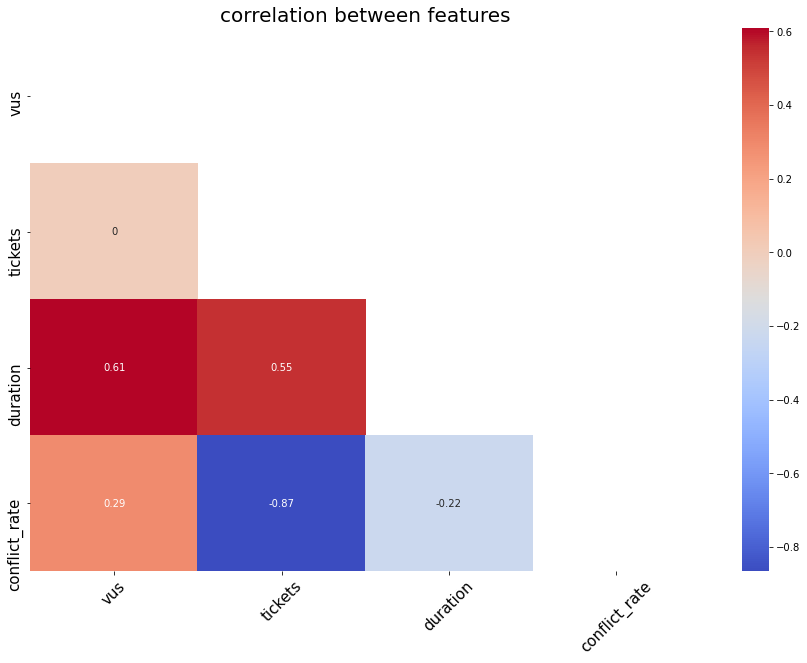

In [19]:
# print(p_df.mean())
show_mean_duration_for(p_df,min_conflict_rate=1, groupby_columns=plock_columns)
# show_mean_duration_for(p_df, max_vus=50, groupby_columns=plock_columns)
feature = [col for col in p_df.columns if col not in ['duration']]
target = 'duration'
corr_between_feature_target(p_df, feature, target)

# 4. 분산 락

## 4.1 분산 락 데이터 확인

In [20]:
d_df = d_df.loc[d_df.waitTime >= 1000,:]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(d_df.loc[:, ['vus','tickets','waitTime','leaseTime']].sort_values(['vus', 'tickets']))

     vus  tickets  waitTime  leaseTime
36    10       10      1000       1000
37    10       10      1000       1500
38    10       10      1000        500
39    10       10      2000       1000
40    10       10      2000       1500
41    10       10      2000        500
42    10       10      3000       1000
43    10       10      3000       1500
44    10       10      3000        500
18    10      100      1000       1000
19    10      100      1000       1500
20    10      100      1000        500
21    10      100      2000       1000
22    10      100      2000       1500
23    10      100      2000        500
24    10      100      3000       1000
25    10      100      3000       1500
26    10      100      3000        500
0     10     1000      1000       1000
1     10     1000      1000       1500
2     10     1000      1000        500
3     10     1000      2000       1000
4     10     1000      2000       1500
5     10     1000      2000        500
6     10     1000      30

## 4.2 waitTime, leaseTime별 duration 확인

In [21]:
show_mean_duration_for(d_df,max_conflict_rate=1, groupby_columns=dlock_columns)
show_mean_duration_for(d_df,min_conflict_rate=1, groupby_columns=dlock_columns)
# show_mean_duration_for(d_df, max_vus=50, groupby_columns=dlock_columns)
# feature = [col for col in d_df.columns if col not in ['duration']]
# target = 'duration'
# corr_between_feature_target(d_df, feature, target)


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 1.00) 조건에서의 통계 분석

duration 순으로 상위 5개
    vus  tickets  duration  conflict_rate  waitTime  leaseTime
41   10       10    134.69            1.0      2000        500
39   10       10    135.55            1.0      2000       1000
43   10       10    136.50            1.0      3000       1500
44   10       10    140.05            1.0      3000        500
37   10       10    140.99            1.0      1000       1500

 ['waitTime', 'leaseTime'] 별 duration 평균값
                      duration
waitTime leaseTime            
1000     500        293.477500
         1000       346.498000
         1500       335.598000
2000     500        468.537143
         1000       468.808571
         1500       485.277143
3000     500        474.605714
         1000       485.610000
         1500       472.855714

 ['waitTime', 'leaseTime'] 별 duration 최소값
                    duration
waitTime leaseTime          
1000     500      

# 5. 전체 데이터 통계

In [22]:
df.sort_values(['vus','tickets','duration']).groupby(['vus','tickets']).head(3)

,lock,vus,tickets,minBackoff,maxBackoff,retry,waitTime,leaseTime,duration,pass_rate,conflict_rate
182,o-lock,10,10,100,200,90,0,0,112.04,1.0,1.00
180,o-lock,10,10,100,200,30,0,0,113.56,1.0,1.00
245,p-lock,10,10,0,0,0,0,0,115.64,1.0,1.00
177,o-lock,10,100,100,400,30,0,0,61.67,1.0,0.10
173,o-lock,10,100,100,200,90,0,0,61.80,1.0,0.10
171,o-lock,10,100,100,200,30,0,0,62.55,1.0,0.10
168,o-lock,10,1000,100,400,30,0,0,232.30,1.0,0.01
167,o-lock,10,1000,100,300,90,0,0,235.88,1.0,0.01
164,o-lock,10,1000,100,200,90,0,0,238.71,1.0,0.01
208,o-lock,30,10,100,200,60,0,0,126.31,1.0,3.00


## 5.1 상위 5개 & vus, tickets 별 duration 확인

In [23]:
show_mean_duration_for(df.loc[df.pass_rate >= pass_rate, :], groupby_columns=['lock', 'vus', 'tickets'])


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 10000000.00) 조건에서의 통계 분석

duration 순으로 상위 5개
       lock  vus  tickets  minBackoff  maxBackoff  retry  waitTime  leaseTime  \
177  o-lock   10      100         100         400     30         0          0   
173  o-lock   10      100         100         200     90         0          0   
171  o-lock   10      100         100         200     30         0          0   
175  o-lock   10      100         100         300     60         0          0   
174  o-lock   10      100         100         300     30         0          0   

     duration  pass_rate  conflict_rate  
177     61.67        1.0            0.1  
173     61.80        1.0            0.1  
171     62.55        1.0            0.1  
175     63.37        1.0            0.1  
174     64.33        1.0            0.1  

 ['lock', 'vus', 'tickets'] 별 duration 평균값
                      duration
lock   vus tickets            
d-lock 10  10       163.88823

## 5.2 conflict_rate가 0.5 이하인 데이터에 대해 5.1

In [24]:
show_mean_duration_for(df.loc[df.pass_rate >= pass_rate, :], max_conflict_rate=1, groupby_columns=['lock', 'vus', 'tickets'])


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 0.00, max_conflict_rate : 1.00) 조건에서의 통계 분석

duration 순으로 상위 5개
       lock  vus  tickets  minBackoff  maxBackoff  retry  waitTime  leaseTime  \
177  o-lock   10      100         100         400     30         0          0   
173  o-lock   10      100         100         200     90         0          0   
171  o-lock   10      100         100         200     30         0          0   
175  o-lock   10      100         100         300     60         0          0   
174  o-lock   10      100         100         300     30         0          0   

     duration  pass_rate  conflict_rate  
177     61.67        1.0            0.1  
173     61.80        1.0            0.1  
171     62.55        1.0            0.1  
175     63.37        1.0            0.1  
174     64.33        1.0            0.1  

 ['lock', 'vus', 'tickets'] 별 duration 평균값
                      duration
lock   vus tickets            
d-lock 10  10       163.888235
     

## 5.3 conflict_rate가 1 이상인 데이터에 대해 5.1

In [25]:
show_mean_duration_for(df.loc[df.pass_rate >= pass_rate, :], min_conflict_rate=1, groupby_columns=['lock', 'vus', 'tickets'])    


(min_vus : 0, max_vus : 10000000, min_conflict_rate : 1.00, max_conflict_rate : 10000000.00) 조건에서의 통계 분석

duration 순으로 상위 5개
       lock  vus  tickets  minBackoff  maxBackoff  retry  waitTime  leaseTime  \
182  o-lock   10       10         100         200     90         0          0   
180  o-lock   10       10         100         200     30         0          0   
245  p-lock   10       10           0           0      0         0          0   
181  o-lock   10       10         100         200     60         0          0   
208  o-lock   30       10         100         200     60         0          0   

     duration  pass_rate  conflict_rate  
182    112.04        1.0            1.0  
180    113.56        1.0            1.0  
245    115.64        1.0            1.0  
181    120.27        1.0            1.0  
208    126.31        1.0            3.0  

 ['lock', 'vus', 'tickets'] 별 duration 평균값
                      duration
lock   vus tickets            
d-lock 10  10       163.88823